In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pymysql
from sklearn import model_selection
from sklearn import tree
from sklearn import metrics

In [2]:
#建立游标，读取数据
con=pymysql.connect(host='10.100.143.243',port=3310,user='std_risk4'\
                   ,passwd='GTDhG3p5',db='std_risk_analysis',charset='utf8')
cur=con.cursor()
cur.execute('select * from std_risk_analysis.hxg_base_AppRisk')

### 关闭数据库库连接 否则影响mysql的查询
con.commit()  
cur.close()  
con.close() 

In [3]:
#查看字段名称 并形成一个字段名的list
cur.description  
dat=list(cur.fetchall())
data_dict=[]
for field in cur.description:
    data_dict.append(field[0])
        
#形成数据框
data=pd.DataFrame(dat,columns=data_dict)
data.columns

Index(['transport_id', 'amt_decision_w', 'granted_amt_W6', 'granted_amt_W',
       'amt_loan_w', 'bug_loan', 'term_byTransport_id', 'apr_byTransport_id',
       'cnt_loan', 'amt_loan', 'month_release', 'MobDr1to3_od1',
       'MobDr1to3_od10', 'MobDr1to3_od15', 'MobDr1to3_od30',
       'MobDr1to3_od1_bal', 'MobDr1to3_od10_bal', 'MobDr1to3_od15_bal',
       'MobDr1to3_od30_bal', 'MobDr1to6_od1_bal', 'MobDr1to6_od10_bal',
       'MobDr1to6_od15_bal', 'MobDr1to6_od30_bal', 'fpd1', 'fpd15', 'fpd30',
       'flag_loan', 'num', 'customer_name', 'gender', 'age', 'province',
       'city', 'amt_apply_w', 'rate_dec_apl', 'initial_amt_w',
       'fluctuate_amt_w', 'test_amt_w', 'cms_final_amt_w', 'year_decision',
       'month_decision', 'day_decision', 'week_decision', 'max_platform',
       'platform_import', 'rate', 'final_rate', 'final_rate_new', 'gmv12',
       'max_active_days', 'rf_score', 'RF_score_v4', 'code_risk_policy',
       'revolving_type_apply', 'channel', 'shop_year', 'dataloan_

In [4]:
dat1=data.loc[:,['transport_id','flag_loan','amt_decision_w','granted_amt_W6','granted_amt_W','age'\
            ,'amt_apply_w','gmv12','max_active_days','rf_score','RF_score_v4'\
           ]]
dat1.head()

,transport_id,flag_loan,amt_decision_w,granted_amt_W6,granted_amt_W,age,amt_apply_w,gmv12,max_active_days,rf_score,RF_score_v4
0,167563,0,5.50000000000000,4.131404255,5.5000,26,1.0000,0.0000,-1,,0
1,98208,1,0.20000000000000,0.524166667,0.2000,22,10.0000,0.0000,-1,56,None
2,97949,0,103.90000000000000,103.900000000,103.9000,22,200.0000,0.0000,-1,,None
3,130593,1,1.94864864864865,2.023404255,2.3000,22,30.0000,1153.0700,548,56,None
4,6822,1,10.00000000000000,7.872340426,10.0000,30,10.0000,115082.3264,3643,24,None


In [5]:
dat1=dat1.dropna()
dat1['rf_score']=np.where(dat1['rf_score']=='',-1,dat1['rf_score'])

In [6]:
print(data.shape)
print(data.loc[data.flag_loan==1].shape)
print(data.loc[data.flag_loan==0].shape)

(48819, 62)
(39070, 62)
(9749, 62)


In [7]:
## 下采样策略
lo_a_ind=dat1.loc[data.flag_loan==1].index
lo_a_getLow=np.random.choice(lo_a_ind,9609)
dat1_a=dat1.loc[lo_a_getLow,:]
dat1_b=dat1.loc[data.flag_loan==0]
print(dat1_a.shape)
print(dat1_b.shape)
dat2=pd.concat([dat1_a,dat1_b],axis=0)
dat2=dat2.drop(['transport_id'],axis=1)
print(dat2.shape)

(9609, 11)
(4523, 11)
(14132, 10)


In [8]:
## train and test split
dat_bas=dat2.drop(columns=['flag_loan'])
dat_tar=dat2.loc[:,['flag_loan']]
X_train,X_test,Y_train,Y_test=model_selection.train_test_split(dat_bas,dat_tar,test_size=0.3,random_state=555)
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(9892, 9)
(9892, 1)
(4240, 9)
(4240, 1)


In [9]:
dtr=tree.DecisionTreeClassifier(max_depth=8)    ##  预剪枝，调整深度
dtr.fit(X_train,Y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=8,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [10]:
## 检验在train 集上的分类效果
pre_train=dtr.predict(X_train)

# 精确度
print('精确度:\n',metrics.accuracy_score(pre_train,Y_train))
# 模型评估报告
print('\n评估报告:',metrics.classification_report(pre_train,Y_train))
print('\n混淆矩阵:\n',metrics.confusion_matrix(pre_train,Y_train))

精确度:
 0.7732511120097049

评估报告:              precision    recall  f1-score   support

          0       0.49      0.71      0.58      2195
          1       0.91      0.79      0.84      7697

avg / total       0.81      0.77      0.79      9892


混淆矩阵:
 [[1567  628]
 [1615 6082]]


Text(0,0.5,'Sensitivity')

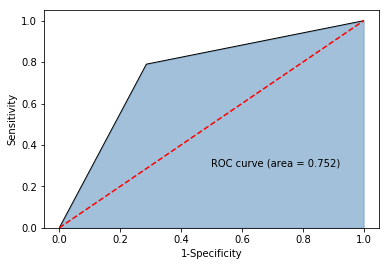

In [11]:
fpr,tpr,threshold = metrics.roc_curve(pre_train, Y_train)

# 计算AUC的值
roc_auc = metrics.auc(fpr,tpr)
# 绘制面积图
plt.stackplot(fpr, tpr, color='steelblue', alpha = 0.5, edgecolor = 'black')
# 添加边际线
plt.plot(fpr, tpr, color='black', lw = 1)
# 添加对角线
plt.plot([0,1],[0,1], color = 'red', linestyle = '--')
# 添加文本信息
plt.text(0.5,0.3,'ROC curve (area = %0.3f)' % roc_auc)
# 添加x轴与y轴标签
plt.xlabel('1-Specificity')
plt.ylabel('Sensitivity')
# 显示图形

In [12]:
## 检验在test 集上的分类效果
pre_test=dtr.predict(X_test)

# 精确度
print('精确度:\n',metrics.accuracy_score(pre_test,Y_test))
# 模型评估报告
print('\n评估报告:',metrics.classification_report(pre_test,Y_test))
print('\n混淆矩阵:\n',metrics.confusion_matrix(pre_test,Y_test))

精确度:
 0.7254716981132076

评估报告:              precision    recall  f1-score   support

          0       0.43      0.59      0.50       967
          1       0.86      0.77      0.81      3273

avg / total       0.76      0.73      0.74      4240


混淆矩阵:
 [[ 572  395]
 [ 769 2504]]


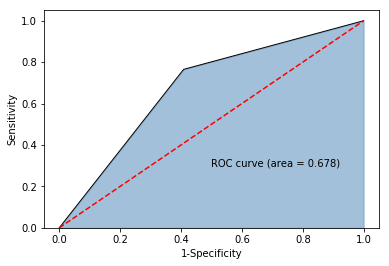

In [13]:
fpr,tpr,threshold = metrics.roc_curve(pre_test, Y_test)

# 计算AUC的值
roc_auc = metrics.auc(fpr,tpr)
# 绘制面积图
plt.stackplot(fpr, tpr, color='steelblue', alpha = 0.5, edgecolor = 'black')
# 添加边际线
plt.plot(fpr, tpr, color='black', lw = 1)
# 添加对角线
plt.plot([0,1],[0,1], color = 'red', linestyle = '--')
# 添加文本信息
plt.text(0.5,0.3,'ROC curve (area = %0.3f)' % roc_auc)
# 添加x轴与y轴标签
plt.xlabel('1-Specificity')
plt.ylabel('Sensitivity')
# 显示图形
plt.show()

In [14]:
from IPython.display import Image 
import graphviz 
import pydotplus 
dot_data = tree.export_graphviz(dtr, out_file=None,  #regr_1 是对应分类器
                         feature_names=X_train.columns,   #对应特征的名字
                         class_names=X_train.columns,    #对应类别的名字
                         filled=True, rounded=True,  
                         special_characters=True)  
graph = pydotplus.graph_from_dot_data(dot_data)  
graph.write_png('rateLoan_deciTree.png')    #保存图像
Image(graph.create_png())

InvocationException: GraphViz's executables not found